In [7]:
import mediapipe as mp
import cv2
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np
import matplotlib.pyplot as plt
import json

In [2]:
# 将预测出的关节点在图中标出
def draw_landmarks_on_image(rgb_image, detection_result):
    pose_landmarks_list = detection_result.pose_landmarks
    annotated_image = np.copy(rgb_image)

    # 循环每个关节点进行标注
    for idx in range(len(pose_landmarks_list)):
        pose_landmarks = pose_landmarks_list[idx]

        # 标出标记点
        pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
        pose_landmarks_proto.landmark.extend(
            [
                landmark_pb2.NormalizedLandmark(
                    x=landmark.x, y=landmark.y, z=landmark.z
                )
                for landmark in pose_landmarks
            ]
        )
        solutions.drawing_utils.draw_landmarks(
            annotated_image,
            pose_landmarks_proto,
            solutions.pose.POSE_CONNECTIONS,
            solutions.drawing_styles.get_default_pose_landmarks_style(),
        )
    return annotated_image

In [21]:
def run_pose_landmark_model(video_path, _show_video=False):
    BaseOptions = mp.tasks.BaseOptions
    PoseLandmarker = mp.tasks.vision.PoseLandmarker
    PoseLandmarkerOptions = mp.tasks.vision.PoseLandmarkerOptions
    VisionRunningMode = mp.tasks.vision.RunningMode

    model_path = "./models/pose_landmarker.task"

    # 以视频模式创建姿态标记模型实例
    options = PoseLandmarkerOptions(
        base_options=BaseOptions(model_asset_path=model_path),
        running_mode=VisionRunningMode.VIDEO,
    )

    with PoseLandmarker.create_from_options(options) as landmarker:
        video = cv2.VideoCapture(video_path)  # 加载视频
        frame_cnt = 0  # 设置帧时间戳

        # 判断视频是否被正确打开
        if video.isOpened():
            open, frame = video.read()
        else:
            open = False
            print("---------video loading failed---------")

        # 设置显示窗口大小
        if _show_video:
            cv2.namedWindow("frame", 0)
            cv2.resizeWindow("frame", 1000, 600)

        # annotated_images = []
        pose_landmarker_results = []

        # 运行pose landmark model
        while open:
            mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame)
            pose_landmarker_result = landmarker.detect_for_video(mp_image, frame_cnt)
            pose_landmarker_results.append(pose_landmarker_result)
            
            # annotated_images.append(annotated_image)

            # 生成标注过的图像
            # 展示每一帧画面
            if _show_video:
                annotated_image = draw_landmarks_on_image(frame, pose_landmarker_result)
                cv2.imshow("frame", annotated_image)

            if cv2.waitKey(1) & 0xFF == 27:
                break

            open, frame = video.read()
            frame_cnt += 1
            
        video.release()
        cv2.destroyAllWindows()

    return pose_landmarker_results, frame_cnt

In [40]:
# 获取关节点坐标和视频帧数
pose_landmarker_results_test, frame_num = run_pose_landmark_model(video_path="./modules/sports/pullup/video/test.mp4")

In [42]:
frame_num, len(pose_landmarker_results_test)

(195, 195)

In [44]:
# 将得到的关节点信息转换为ndarray
def landmarks2vec(pose_landmarks):
    vec2d = []
    for pose in pose_landmarks:
        vec1d = []
        pose_landmarks_list = pose.pose_landmarks[0]
        for idx in range(len(pose_landmarks_list)):
            x = pose_landmarks_list[idx].x
            y = pose_landmarks_list[idx].y
            z = pose_landmarks_list[idx].z
            v = pose_landmarks_list[idx].visibility
            p = pose_landmarks_list[idx].presence
            vec1d.append([x, y, z, v, p])
        vec2d.append(vec1d)
    vec3d = np.array(vec2d)
    return vec3d

In [45]:
vec = landmarks2vec(pose_landmarker_results_test)   # 转换为特征向量
vec.shape  # 结果分别对应：(视频的帧数, 关节点的个数, 每个关节点的相关信息的个数)

(195, 33, 5)

In [10]:
def fixed(vec1):
    for i in range(vec1.shape[0]):
        print(vec1[i][15][0], vec1[i][15][0])

特征工程
1. 对骨架进行放缩，减小人体体型的差距，不同运动的缩放比例的选取也不同，例如引体向上中可以以两人肩膀间距的比值作为缩放比例
2. 将骨架平移到一起进行对齐，但是不同运动的平移方式可能有所不同，例如引体向上，由于运动过程中人的手位置几乎固定不变，所以选择左手手腕(15号点)作为参考点，优先对齐左手手肘

In [8]:
# 加载json
def load_json(path):
    with open(path) as f:
        data = json.load(f)["data"]
    return data


# 加载数据
standard = load_json("./modules/sports/pullup/dataset/standard_video.json")
test = load_json("./modules/sports/pullup/dataset/test_video.json")
standard = np.array(standard)
test = np.array(test)


"""
这一步有一个难点：有时候人像可能会被识别反，简单来说左手被识别成右手，导致最终我们有可能将测试视频的左手与标准视频的右手对齐。
为了克服这一难点，我们在一开始的时候对左手腕和右手腕的距离进行测量比较，以确定是否需要镜像翻转，如需要则翻转之。
"""

"""
该函数检测是否需要水平翻转图像
coord1是标准视频的左手腕坐标
coord2和coord3是测试视频的左手腕和右手腕的坐标
"""
def is_reverted(coord1, coord2, coord3):
    dist1 = np.sqrt(np.sum(np.square(coord1 - coord2)))
    dist2 = np.sqrt(np.sum(np.square(coord1 - coord3)))
    return dist1 - dist2 > 0


# 该函数可以水平翻转图像
def revert(frame):
    for coord_idx in range(1, frame.shape[0], 2):
        frame[coord_idx][0], frame[coord_idx + 1][0] = (
            frame[coord_idx + 1][0],
            frame[coord_idx][0],
        )
        frame[coord_idx][1], frame[coord_idx + 1][1] = (
            frame[coord_idx + 1][1],
            frame[coord_idx][1],
        )


def transformX(vec1, vec2, pos=15):
    # 检测是否需要水平翻转
    for frame_idx in range(vec2.shape[0]):
        if is_reverted(
            np.array([vec1[0][pos][0], vec1[0][pos][1]]),
            np.array([vec2[frame_idx][pos][0], vec2[frame_idx][pos][1]]),
            np.array([vec2[frame_idx][pos + 1][0], vec2[frame_idx][pos + 1][1]]),
        ):
            revert(vec2[frame_idx])  # 翻转
    return vec2


"""
该函数实现骨骼的放缩，x轴上的缩放比例一般以双肩距离的比值作为缩放倍数，
y轴上的缩放比例则应该以测试人员和标准视频中的人的身高的比值作为缩放倍数。
"""
def regularize(vec1, vec2):
    # 以初始帧的肩距作为标准
    ratio_x = np.fabs(vec1[0][11][0] - vec1[0][12][0]) / np.fabs(
        vec2[0][11][0] - vec2[0][12][0]
    )
    ratio_y = np.fabs(vec1[0][11][1] - vec1[0][12][1]) / np.fabs(
        vec2[0][11][1] - vec2[0][12][1]
    )
    for frame_idx in range(vec2.shape[0]):
        for coord_idx in range(vec2.shape[1]):
            vec2[frame_idx][coord_idx][0] *= ratio_x
            vec2[frame_idx][coord_idx][1] /= ratio_y
    return vec2


"""
该函数实现引体向上的对齐骨骼，pos是参照点的索引，vec1是标准视频的特征向量，vec2是测试视频的特征向量。
由于引体向上运动过程中人的手位置几乎固定不变，所以选择左手手腕(15号点)作为参考。
"""
def align_skeleton_pullup(vec1, vec2, pos=15):
    # 先将标准视频的相对固定的关节点对齐(自己跟自己对齐)
    for frame_idx in range(vec1.shape[0]):  # 遍历每一帧
        xd_standard = vec1[0][pos][0] - vec1[frame_idx][pos][0]
        yd_standard = vec1[0][pos][1] - vec1[frame_idx][pos][1]
        for coord_idx in range(vec1.shape[1]):  # 遍历每一个关节点
            vec1[frame_idx][coord_idx][0] += xd_standard
            vec1[frame_idx][coord_idx][1] += yd_standard

    # 将测试视频与标准视频对齐
    # 选取标准视频的第一帧的左手手肘坐标作为平移参照点
    for frame_idx in range(vec2.shape[0]):  # 遍历每一帧
        xd_test = vec1[0][pos][0] - vec2[frame_idx][pos][0]
        yd_test = vec1[0][pos][1] - vec2[frame_idx][pos][1]
        for coord_idx in range(vec2.shape[1]):  # 遍历每一个关节点
            vec2[frame_idx][coord_idx][0] += xd_test
            vec2[frame_idx][coord_idx][1] += yd_test

    return vec1, vec2

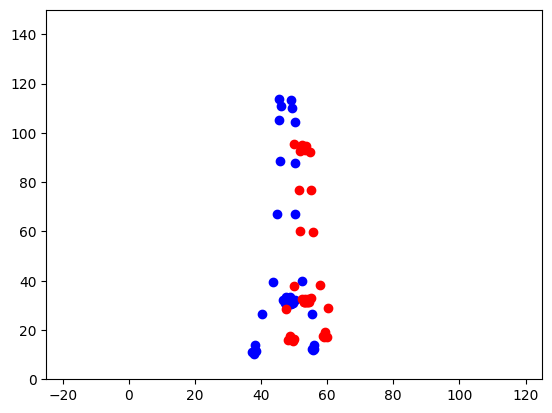

In [9]:
# 数据处理之前
frame_idx = 0
plt.figure()
for coord_idx in range(standard.shape[1]):
    plt.scatter(
        100 * standard[frame_idx][coord_idx][0],
        100 * standard[frame_idx][coord_idx][1],
        c="b",
    )
for coord_idx in range(test.shape[1]):
    plt.scatter(
        100 * test[frame_idx][coord_idx][0],
        100 * test[frame_idx][coord_idx][1],
        c="r",
    )
plt.xlim((-25, 125))
plt.ylim((0, 150))
plt.show()

In [10]:
# 水平翻转
test = transformX(standard, test)

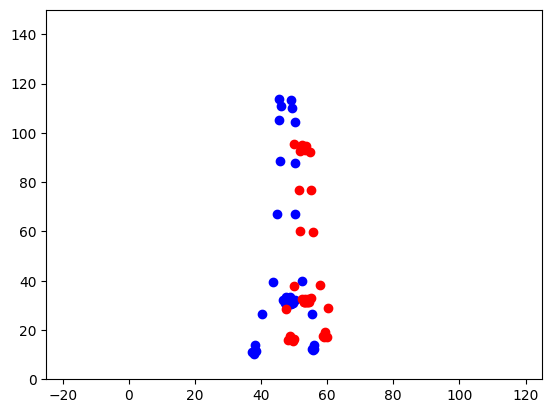

In [11]:
# 水平翻转之后
frame_idx = 0
plt.figure()
for coord_idx in range(standard.shape[1]):
    plt.scatter(
        100 * standard[frame_idx][coord_idx][0],
        100 * standard[frame_idx][coord_idx][1],
        c="b",
    )
for coord_idx in range(test.shape[1]):
    plt.scatter(
        100 * test[frame_idx][coord_idx][0],
        100 * test[frame_idx][coord_idx][1],
        c="r",
    )
plt.xlim((-25, 125))
plt.ylim((0, 150))
plt.show()

In [12]:
test = regularize(standard, test)

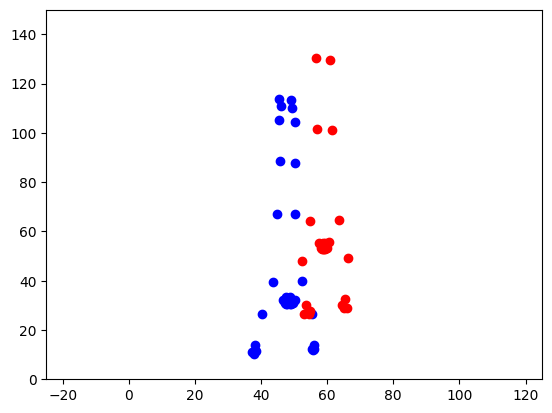

In [13]:
frame_idx = 0
plt.figure()
for coord_idx in range(standard.shape[1]):
    plt.scatter(
        100 * standard[frame_idx][coord_idx][0],
        100 * standard[frame_idx][coord_idx][1],
        c="b",
    )
for coord_idx in range(test.shape[1]):
    plt.scatter(
        100 * test[frame_idx][coord_idx][0],
        100 * test[frame_idx][coord_idx][1],
        c="r",
    )
plt.xlim((-25, 125))
plt.ylim((0, 150))
plt.show()

In [14]:
# 对齐骨骼
standard, test = align_skeleton_pullup(standard, test)

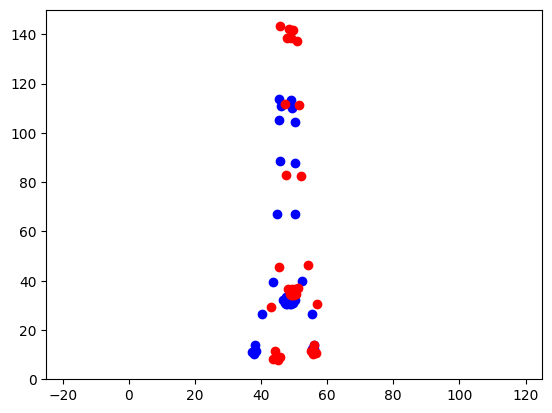

In [15]:
frame_idx = 0
plt.figure()
for coord_idx in range(standard.shape[1]):
    plt.scatter(
        100 * standard[frame_idx][coord_idx][0],
        100 * standard[frame_idx][coord_idx][1],
        c="b",
    )
for coord_idx in range(test.shape[1]):
    plt.scatter(
        100 * test[frame_idx][coord_idx][0],
        100 * test[frame_idx][coord_idx][1],
        c="r",
    )
plt.xlim((-25, 125))
plt.ylim((0, 150))
plt.show()

特征工程结束后，我们使用DTW算法对标准视频和测试视频进行帧对齐，经过这一过程，我们能计算出标准视频和测试视频的姿态相似度

In [37]:
# 计算节点之间的距离(欧氏距离)
def euclidean_dist(landmarks1, landmarks2):
    sum = 0
    for coord_idx in range(landmarks1.shape[0]):
        sum += np.sqrt(np.sum(np.square(landmarks1[coord_idx][0:2] - landmarks2[coord_idx][0:2])))
    return sum


# 时间动态规划，vec1是标准视频，vec2是测试视频
def dynamic_time_warping(vec1, vec2):
    len1, len2 = vec1.shape[0], vec2.shape[0]
    admatrix = [[0 for j in range(len2)] for i in range(len1)]  # 构造初始累计距离矩阵，len1*len2

    # 构造第一列
    for i in range(len1):
        admatrix[i][0] = euclidean_dist(vec1[i], vec2[0])
        if i != 0:
            admatrix[i][0] += admatrix[i - 1][0]

    # 构造第一行
    for i in range(len2):
        admatrix[0][i] = euclidean_dist(vec1[0], vec2[i])
        if i != 0:
            admatrix[0][i] += admatrix[0][i - 1]

    # 填补剩余位置
    for i in range(1, len1):
        for j in range(1, len2):
            admatrix[i][j] = euclidean_dist(vec1[i], vec2[j]) + min(admatrix[i - 1][j], admatrix[i][j - 1],
                                                          admatrix[i - 1][j - 1])

    # for i in range(len1 - 1, -1, -1):
    #     for j in range(0, len2):
    #         print('%02d' % admatrix[i][j], end=' ')
    #     print()

    # 寻找匹配路径
    aligned = []
    x, y = len1 - 1, len2 - 1
    match = [[False for j in range(len2)] for i in range(len1)]
    while x != 0 and y != 0:
        match[x][y] = True
        aligned.append(x)
        cads = [admatrix[x - 1][y] if x != 0 else 0xfff, admatrix[x][y - 1] if y != 0 else 0xfff,
                admatrix[x - 1][y - 1] if x != 0 and y != 0 else 0xfff]
        nextstep = np.argmin(cads)
        if nextstep == 0:
            x -= 1
        elif nextstep == 1:
            y -= 1
        else:
            x -= 1
            y -= 1
    match[x][y] = True
    aligned.append(x)

    # 打印匹配完成后的路径
    # for i in range(len1 - 1, -1, -1):
    #     for j in range(0, len2):
    #         print('%1d' % int(match[i][j]), end=' ')
    #     print()
    
    # aligned = []    # 对齐的结果，align[i]=x，表示测试视频的第i帧对应标准视频的第x帧
    # for col in range(0, len(match[0])):
    #     for row in range(len(match)):
    #         if match[row][col]:
    #             aligned.append(row)
    #             break

    return np.array(aligned)[::-1]

In [38]:
aligned = dynamic_time_warping(standard, test)
aligned

array([ 0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  3,  4,  5,  6,
        7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
       24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
       41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
       58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74,
       75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91,
       92, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93])

In [27]:
standard.shape, test.shape

((94, 33, 5), (195, 33, 5))

In [34]:
a = np.array([[2, 3], [4, 5]])
print(type(a[0]))

<class 'numpy.ndarray'>
